## tutorial

link:https://colab.research.google.com/drive/1oNxRpRnht2Ogu5Id76YLLg_hkmwy-yKy?usp=sharing#scrollTo=vs2ciyFsFhZz

In [1]:
from __future__ import annotations
import gymnasium as gym
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict,namedtuple,deque
import numpy as np
import math
import random
import matplotlib
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline

In [2]:
env=gym.make("CartPole-v1",render_mode="rgb_array")

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
  from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
Transition = namedtuple('Transition',('state','action','next_state','reward'))

class ReplayMemory(object):
    def __init__(self,capacity):
        self.memory = deque([],maxlen=capacity)
        
    def push(self,*args):
        self.memory.append(Transition(*args))
        
    def sample(self,batch_size):
        return random.sample(self.memory,batch_size)
    
    def __len__(self):
        return len(self.memory)

## DQN

Algorithm of DQN

1. initialize the DQN with random weights

2. 

In [4]:
class DQN(nn.Module):
    # multi-layer perceptron with three layers
    
    # n_observation is input (state of enviroment) to the network
    
    def __init__(self,n_observations,n_actions):
        super(DQN,self).__init__()
        self.layer1 = nn.Linear(n_observations,128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128,n_actions)
        
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
        

In [5]:
#number of transitions samples from the replay buffer
BATCH_SIZE = 128
# GAMMAis the discount factor
GAMMA = 0.99
EPS_START = 0.9 # it is  the starting value of epsilon
EPS_END = 0.05 # it is  the final value of epsilon
#EPS_DECAY controls the rate of exponential decay of epsilon,
#higher means slower decay 
EPS_DECAY = 1000  
TAU = 0.005 #Update rate of the target network
LR = 1e-4 #Learning rate of AdamW optimizer

In [6]:
n_actions = env.action_space.n

state, info = env.reset()

n_observations = len(state)

policy_net = DQN(n_observations,n_actions).to(device)
target_net = DQN(n_observations,n_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(),lr = LR, amsgrad = True)

memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
        
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            """
            1. state: [n_observations,]
            2. output of policy_net: [n_actions,]
            3. t.max(1) return the max of dimension 1 and the return is a tuple (max_value,max_index)
            4. t.max(1)[1]: the index of max value
            """
            return policy_net(state).max(1)[1].view(1,1)
    else:
        return torch.tensor([[env.action_space.sample()]],
                            device=device,dtype=torch.long)
        
episode_durations = []

def plot_duration(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations,dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    
    #shows the 100-episode moving average of the duration
    if(len(durations_t) >= 100):
        means = durations_t.unfold(0,1000,1).mean(1).view(-1)
        means = torch.cat((torch.zeroes(99),means))
        plt.plot(means.numpy())

    plt.pause(0.001) #pause so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [7]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transition = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transition))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),device=device,dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1,action_batch)

    next_state_values = torch.zeros(BATCH_SIZE,device=device)
    
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    #expect q-value for each transition using the target network
    #
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch


    #Compute Huber loss
    #smooth approximation of the mean square error loss , less
    # sensitive
    
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values ,
                    expected_state_action_values.unsqueeze(1))

    #Optimize the model
    optimizer.zero_grad()
    loss.backward()

    #In-place gradient clipping
    #maximum value = 100 to prevent exploding gradient problem
    torch.nn.utils.clip_grad_value_(policy_net.parameters(),100)
    optimizer.step()
    

RuntimeError: maximum size for tensor at dimension 0 is 100 but size is 1000

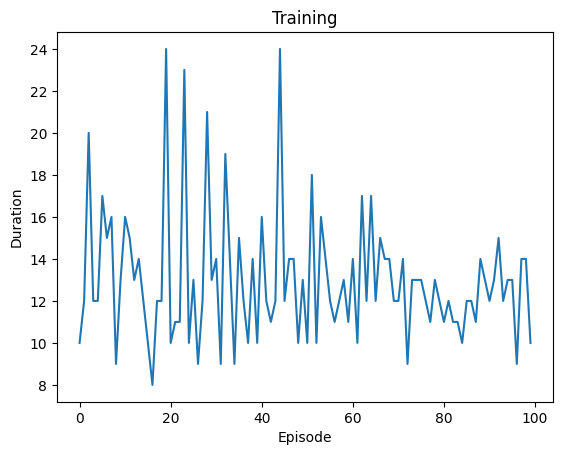

In [8]:
#@title Default title text
if torch.cuda.is_available():
  num_episodes = 600
else:
  num_episodes = 300

#iterate for episodes
for i_episode in range(num_episodes):
  #intialize the environment and get it's state
  state,info = env.reset()
  state = torch.tensor(state,dtype=torch.float32,
                       device=device).unsqueeze(0)
  for t in count():
    action = select_action(state)
    observation , reward , terminated , truncated ,_ = env.step(action.item())
    reward = torch.tensor([reward],device = device)

    # frame = env.render()
    # plt.imshow(frame)
    # plt.show()

    done  = terminated or truncated

    if  terminated:
      next_state = None
    else:
      next_state = torch.tensor(observation,dtype=torch.float32,device=device).unsqueeze(0)  

    #store the transition in memory
    memory.push(state,action,next_state,reward)

    #move to the next state
    state = next_state

    #optimize
    optimize_model()

  #soft update the target network's wright by bledning policy network's weights
  # and target network's weights using a hyperparameter called TAU
    target_net_state_dict  = target_net.state_dict()
    policy_net_state_dict  = target_net.state_dict()

    for key in policy_net_state_dict:
      target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1 - TAU)

    if done:
      episode_durations.append(t + 1)
      plot_duration()
      break

print('Complete')
plot_duration(show_result=True)
plt.ioff()
plt.show()       
